In [1]:
class Args:
    def __init__(self):
        self.outfolder = './fits'
        self.outfilename = 'test'
        self.config_path = '../../../config'
        self.seed = 31452
        self.cuda_no = 2

args = Args()

In [2]:
import os
assert os.path.isdir(args.outfolder)

import torch
import pytorch_lightning as pl
print('torch version: ', torch.__version__)
cuda_no = "cuda:" + str(args.cuda_no)
device = torch.device(cuda_no if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

from hydra.experimental import initialize, compose

import sys
sys.path.append('../starnet_utils/')
from starnet_sleep_dataset import SimulatedStarnetDataset


torch version:  1.7.1
cuda:2


In [3]:
import numpy as np
import time 

In [4]:
from bliss import sleep
from bliss.datasets import simulated, sdss


torch.manual_seed(args.seed)
np.random.seed(args.seed)

In [100]:
print("Training sleep phase")
###################
# load config parameters 
###################
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

print('config overrides: ')
print(overrides)

overrides = [f"{key}={value}" for key, value in overrides.items()]

with initialize(config_path=args.config_path):
    cfg = compose("config", overrides=overrides)

print('config: ')
print(cfg)

Training sleep phase
config overrides: 
{'model': 'sleep_m2', 'dataset': 'm2', 'training': 'm2', 'optimizer': 'm2'}
config: 
{'mode': 'train', 'gpus': 1, 'paths': {'root': '${oc.env:BLISS_HOME}', 'data': '${paths.root}/data', 'models': '${paths.root}/models', 'output': '${paths.root}/output', 'sdss': '${paths.root}/data/sdss'}, 'optimizer': {'name': 'Adam', 'kwargs': {'lr': 0.00098352, 'weight_decay': 8.041e-05}}, 'model': {'name': 'SleepPhase', 'kwargs': {'decoder_kwargs': '${model.decoder.kwargs}', 'encoder_kwargs': '${model.encoder.kwargs}', 'optimizer_params': '${optimizer}'}, 'decoder': {'kwargs': {'n_bands': 2, 'slen': 100, 'tile_slen': 2, 'ptile_slen': 26, 'border_padding': 3, 'max_sources': 5, 'mean_sources': 0.48, 'min_sources': 0, 'f_min': 1000.0, 'f_max': 1000000.0, 'alpha': 0.5, 'psf_params_file': '${paths.root}/data/psField-002583-2-0136.fits', 'prob_galaxy': 0.0, 'background_values': [686.0, 1123.0], 'sdss_bands': [2, 3]}}, 'encoder': {'kwargs': {'n_bands': '${model.decod

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(


In [101]:
cfg.model.decoder.kwargs.update({'n_bands': 1, 
                                 'slen': 300, 
                                 'tile_slen': 10, 
                                 'ptile_slen': 30, 
                                 'border_padding': 5, 
                                 'mean_sources': 0.1, 
                                 'background_values': [680]})

In [102]:
cfg.model.decoder.kwargs.update({'psf_params_file': './psf/zband_psf_simple.npy'})

In [103]:
cfg.model.encoder.kwargs.update({'ptile_slen': 20})

In [104]:
cfg.dataset.kwargs.update({'batch_size': 1})

In [105]:
###################
# initialize data set and model
###################
dataset = SimulatedStarnetDataset(**cfg.dataset.kwargs)
sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [106]:
from matplotlib import pyplot as plt 
%matplotlib inline

In [129]:
out = dataset.get_batch()

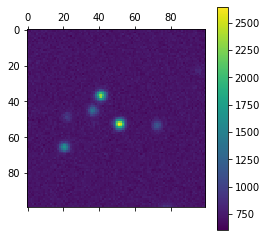

In [130]:
plt.matshow(out['images'].cpu()[0, 0, 0:100, 0:100])
plt.colorbar()